# Prediction on Titanic survivors

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1- Data import

In [3]:
train_rdf = pd.read_csv("./../../01_data/11_raw/train.csv", header=0)
test_rdf = pd.read_csv("./../../01_data/11_raw/test.csv", header=0)
test_rdf.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [4]:
print(train_rdf.isna().sum())
print(test_rdf.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
train_rdf.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

## 2-Cleaning data

In [6]:
train_df = train_rdf.copy()
test_df = test_rdf.copy()

train_df.drop(["Name"], axis=1, inplace=True)
test_df.drop(["Name"], axis=1, inplace=True)

train_df.Cabin.apply(lambda x: 'Unknown' if pd.isna(x) else x)
test_df.Cabin.apply(lambda x: 'Unknown' if pd.isna(x) else x)

train_df = train_df[train_df["Embarked"].notna()]

lec = LabelEncoder()

train_df.Sex = lec.fit_transform(train_df.Sex)
test_df.Sex = lec.transform(test_df.Sex)

train_df.Embarked = lec.fit_transform(train_df.Embarked)
test_df.Embarked = lec.transform(test_df.Embarked)

lec.fit(pd.concat([train_df.Cabin, test_df.Cabin], axis=0))
train_df.Cabin = lec.transform(train_df.Cabin)
test_df.Cabin = lec.transform(test_df.Cabin)

lec.fit(pd.concat([train_df.Ticket, test_df.Ticket], axis=0))
train_df.Ticket = lec.transform(train_df.Ticket)
test_df.Ticket = lec.transform(test_df.Ticket)

train_df.head(3)

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  \
0            1         0       3    1  22.0      1      0     719   7.2500   
1            2         1       1    0  38.0      1      0     815  71.2833   
2            3         1       3    0  26.0      0      0     913   7.9250   

   Cabin  Embarked  
0    185         2  
1    105         0  
2    185         2

In [7]:
train_df.describe()

PassengerId    Survived      Pclass         Sex         Age  \
count   889.000000  889.000000  889.000000  889.000000  712.000000   
mean    446.000000    0.382452    2.311586    0.649044   29.642093   
std     256.998173    0.486260    0.834700    0.477538   14.492933   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     224.000000    0.000000    2.000000    0.000000   20.000000   
50%     446.000000    0.000000    3.000000    1.000000   28.000000   
75%     668.000000    1.000000    3.000000    1.000000   38.000000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            SibSp       Parch      Ticket        Fare       Cabin    Embarked  
count  889.000000  889.000000  889.000000  889.000000  889.000000  889.000000  
mean     0.524184    0.382452  462.103487   32.096681  165.128234    1.535433  
std      1.103705    0.806761  276.547123   49.697504   44.446792    0.792088  
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000  214.000000    7.895800  185.000000    1.000000  
50%      0.000000    0.000000  463.000000   14.454200  185.000000    2.000000  
75%      1.000000    0.000000  715.000000   31.000000  185.000000    2.000000  
max      8.000000    6.000000  927.000000  512.329200  185.000000    2.000000

<Axes: >

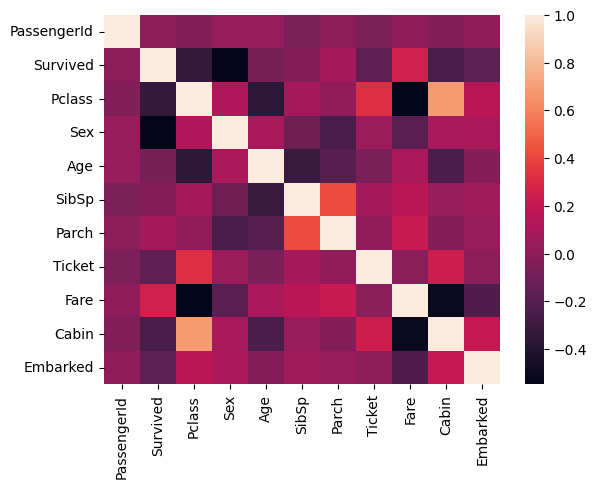

In [8]:
sns.heatmap(train_df.corr())

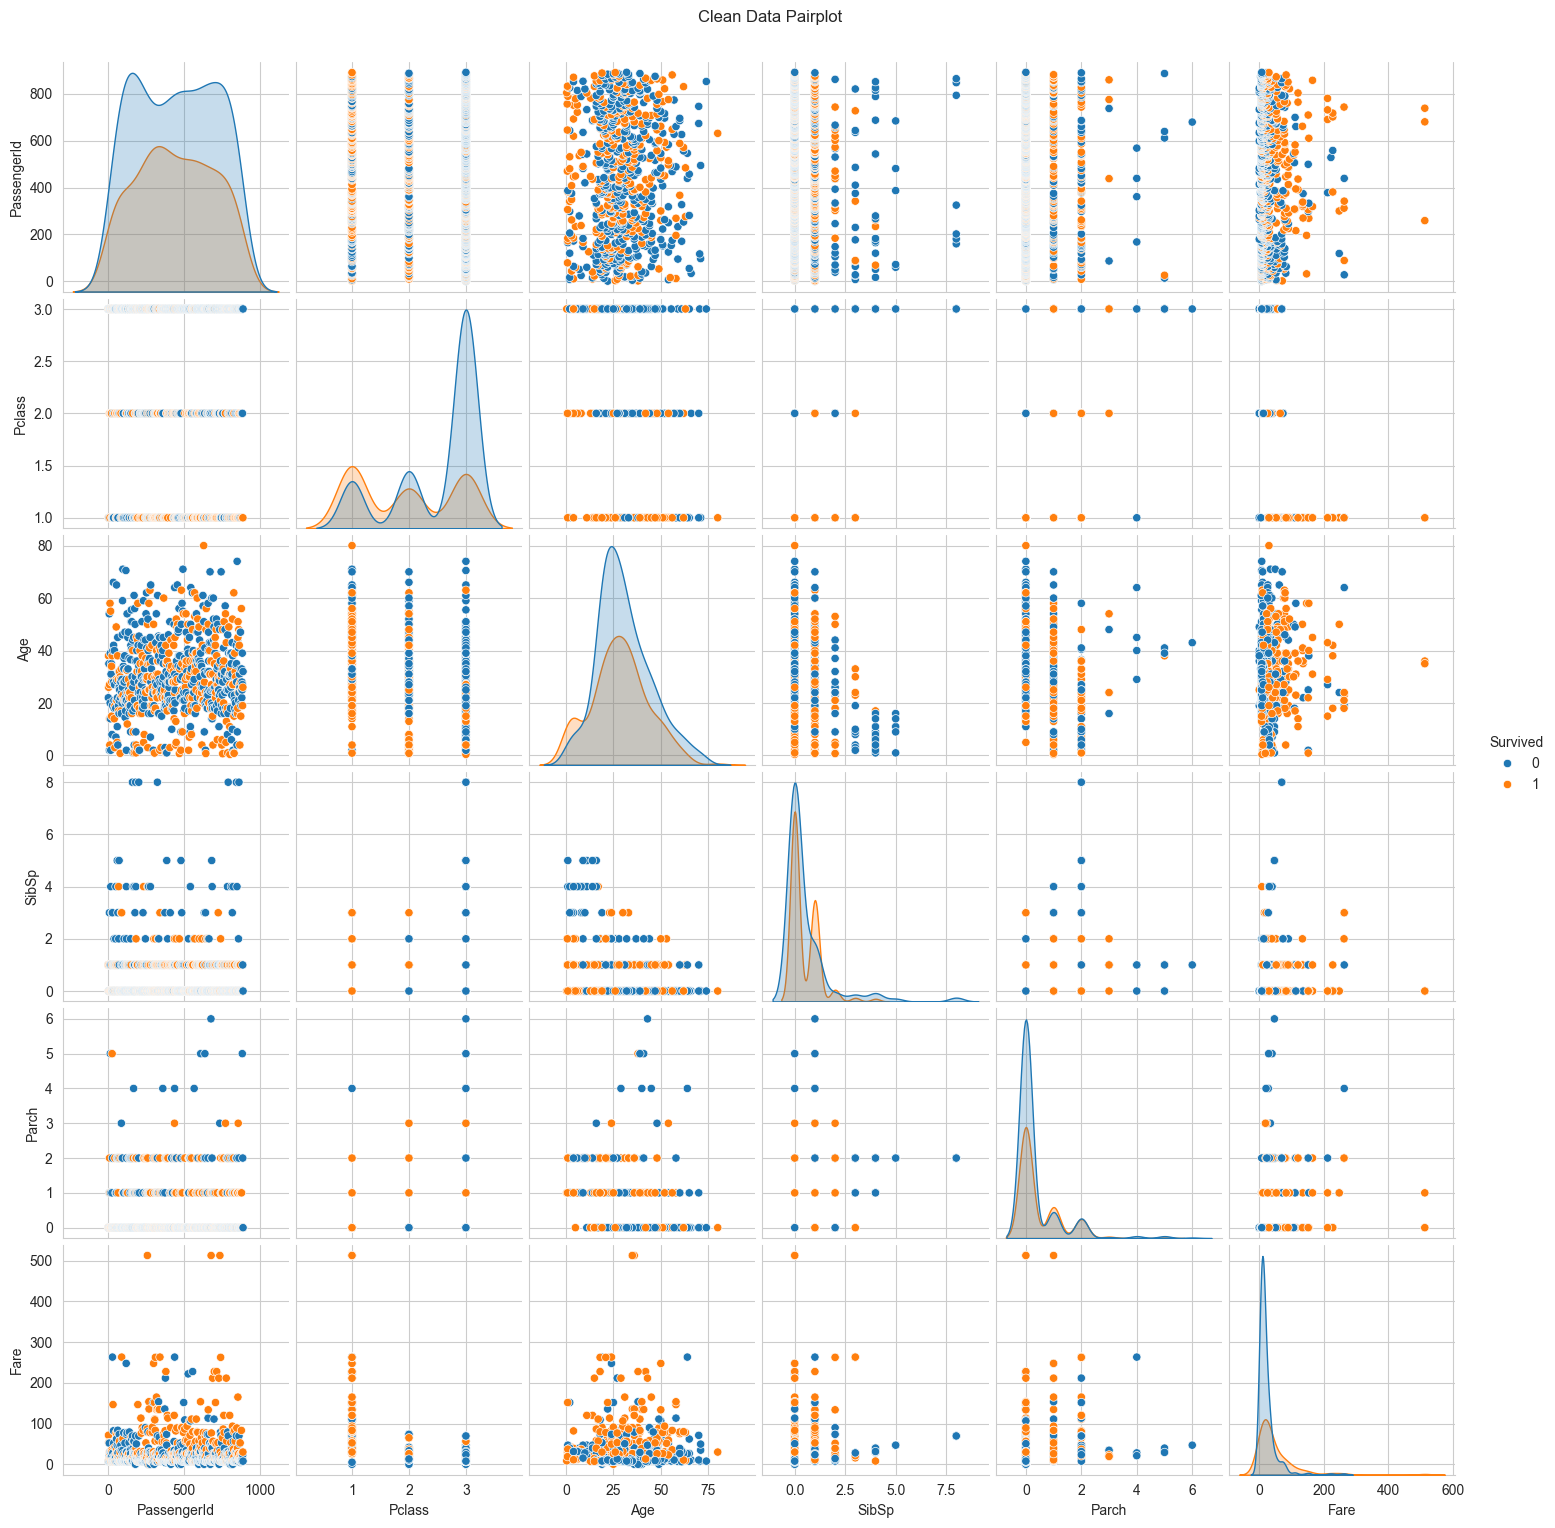

In [9]:
sns.set_style("whitegrid")
#sns.set_palette("hls", 8)
g = sns.pairplot(train_rdf, hue="Survived", palette="tab10")
g.fig.suptitle("Clean Data Pairplot", y=1.02)
plt.show(g)

In [52]:
train_df[["Survived","Pclass","Age"]].groupby(["Pclass","Survived"]).mean()

Age
Pclass Survived           
1      0         43.695312
       1         35.124333
2      0         33.544444
       1         25.901566
3      0         26.555556
       1         20.646118

## 3- Separating data

In [38]:
X_train, y_train = train_df[train_df.columns.difference(["Survived"])], train_df.Survived
X_test = test_df[test_df.columns.difference(["Survived"])]

In [39]:
knn = KNNImputer()
knn.fit( pd.concat([X_train, X_test], axis = 0))
X_train = pd.DataFrame(knn.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns, index=X_test.index)

## 4- XGBoost Training and prediction

In [40]:
acc = make_scorer(accuracy_score)
prec = make_scorer(precision_score)
rec = make_scorer(recall_score)

In [41]:
xgbc = XGBClassifier()
cv = StratifiedKFold(n_splits=5)

acc_scores = cross_val_score(estimator=xgbc, X=X_train, y=y_train, cv=cv, scoring=acc)
prec_scores = cross_val_score(estimator=xgbc, X=X_train, y=y_train, cv=cv, scoring=prec)
rec_scores = cross_val_score(estimator=xgbc, X=X_train, y=y_train, cv=cv, scoring=rec)

print(f"Mean accuracy : {acc_scores.mean()}")
print(f"Mean precision : {prec_scores.mean()}")
print(f"Mean recall : {rec_scores.mean()}")

Mean accuracy : 0.7908398400304704
Mean precision : 0.8290163483772901
Mean recall : 0.6205882352941176


Feature selection

In [42]:
cv = StratifiedKFold(n_splits=5)
selector = SequentialFeatureSelector(estimator=xgbc, n_features_to_select=5, direction="backward", scoring=acc, cv=cv)

In [43]:
selector.fit(X_train, y_train)
selector.get_support()*X_train.columns

Index(['Age', 'Cabin', '', 'Fare', '', '', '', 'Sex', '', 'Ticket'], dtype='object')

Feature add

In [44]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu)**2) / (2 * sigma**2))

In [53]:
X_train["Risk1"] = X_train["Fare"] / np.sqrt(X_train["Pclass"])
X_test["Risk1"] = X_test["Fare"] / np.sqrt(X_test["Pclass"])

X_train["Risk2"] = X_train["Age"] / X_train["Pclass"]
X_test["Risk2"] = X_test["Age"] / X_train["Pclass"]

X_train["Risk3"] = X_train["Age"] / (1 + (1-X_train["Sex"])*2)
X_test["Risk3"] = X_test["Age"] / (1 + (1-X_train["Sex"])*2)

Visualisation of feature transformation

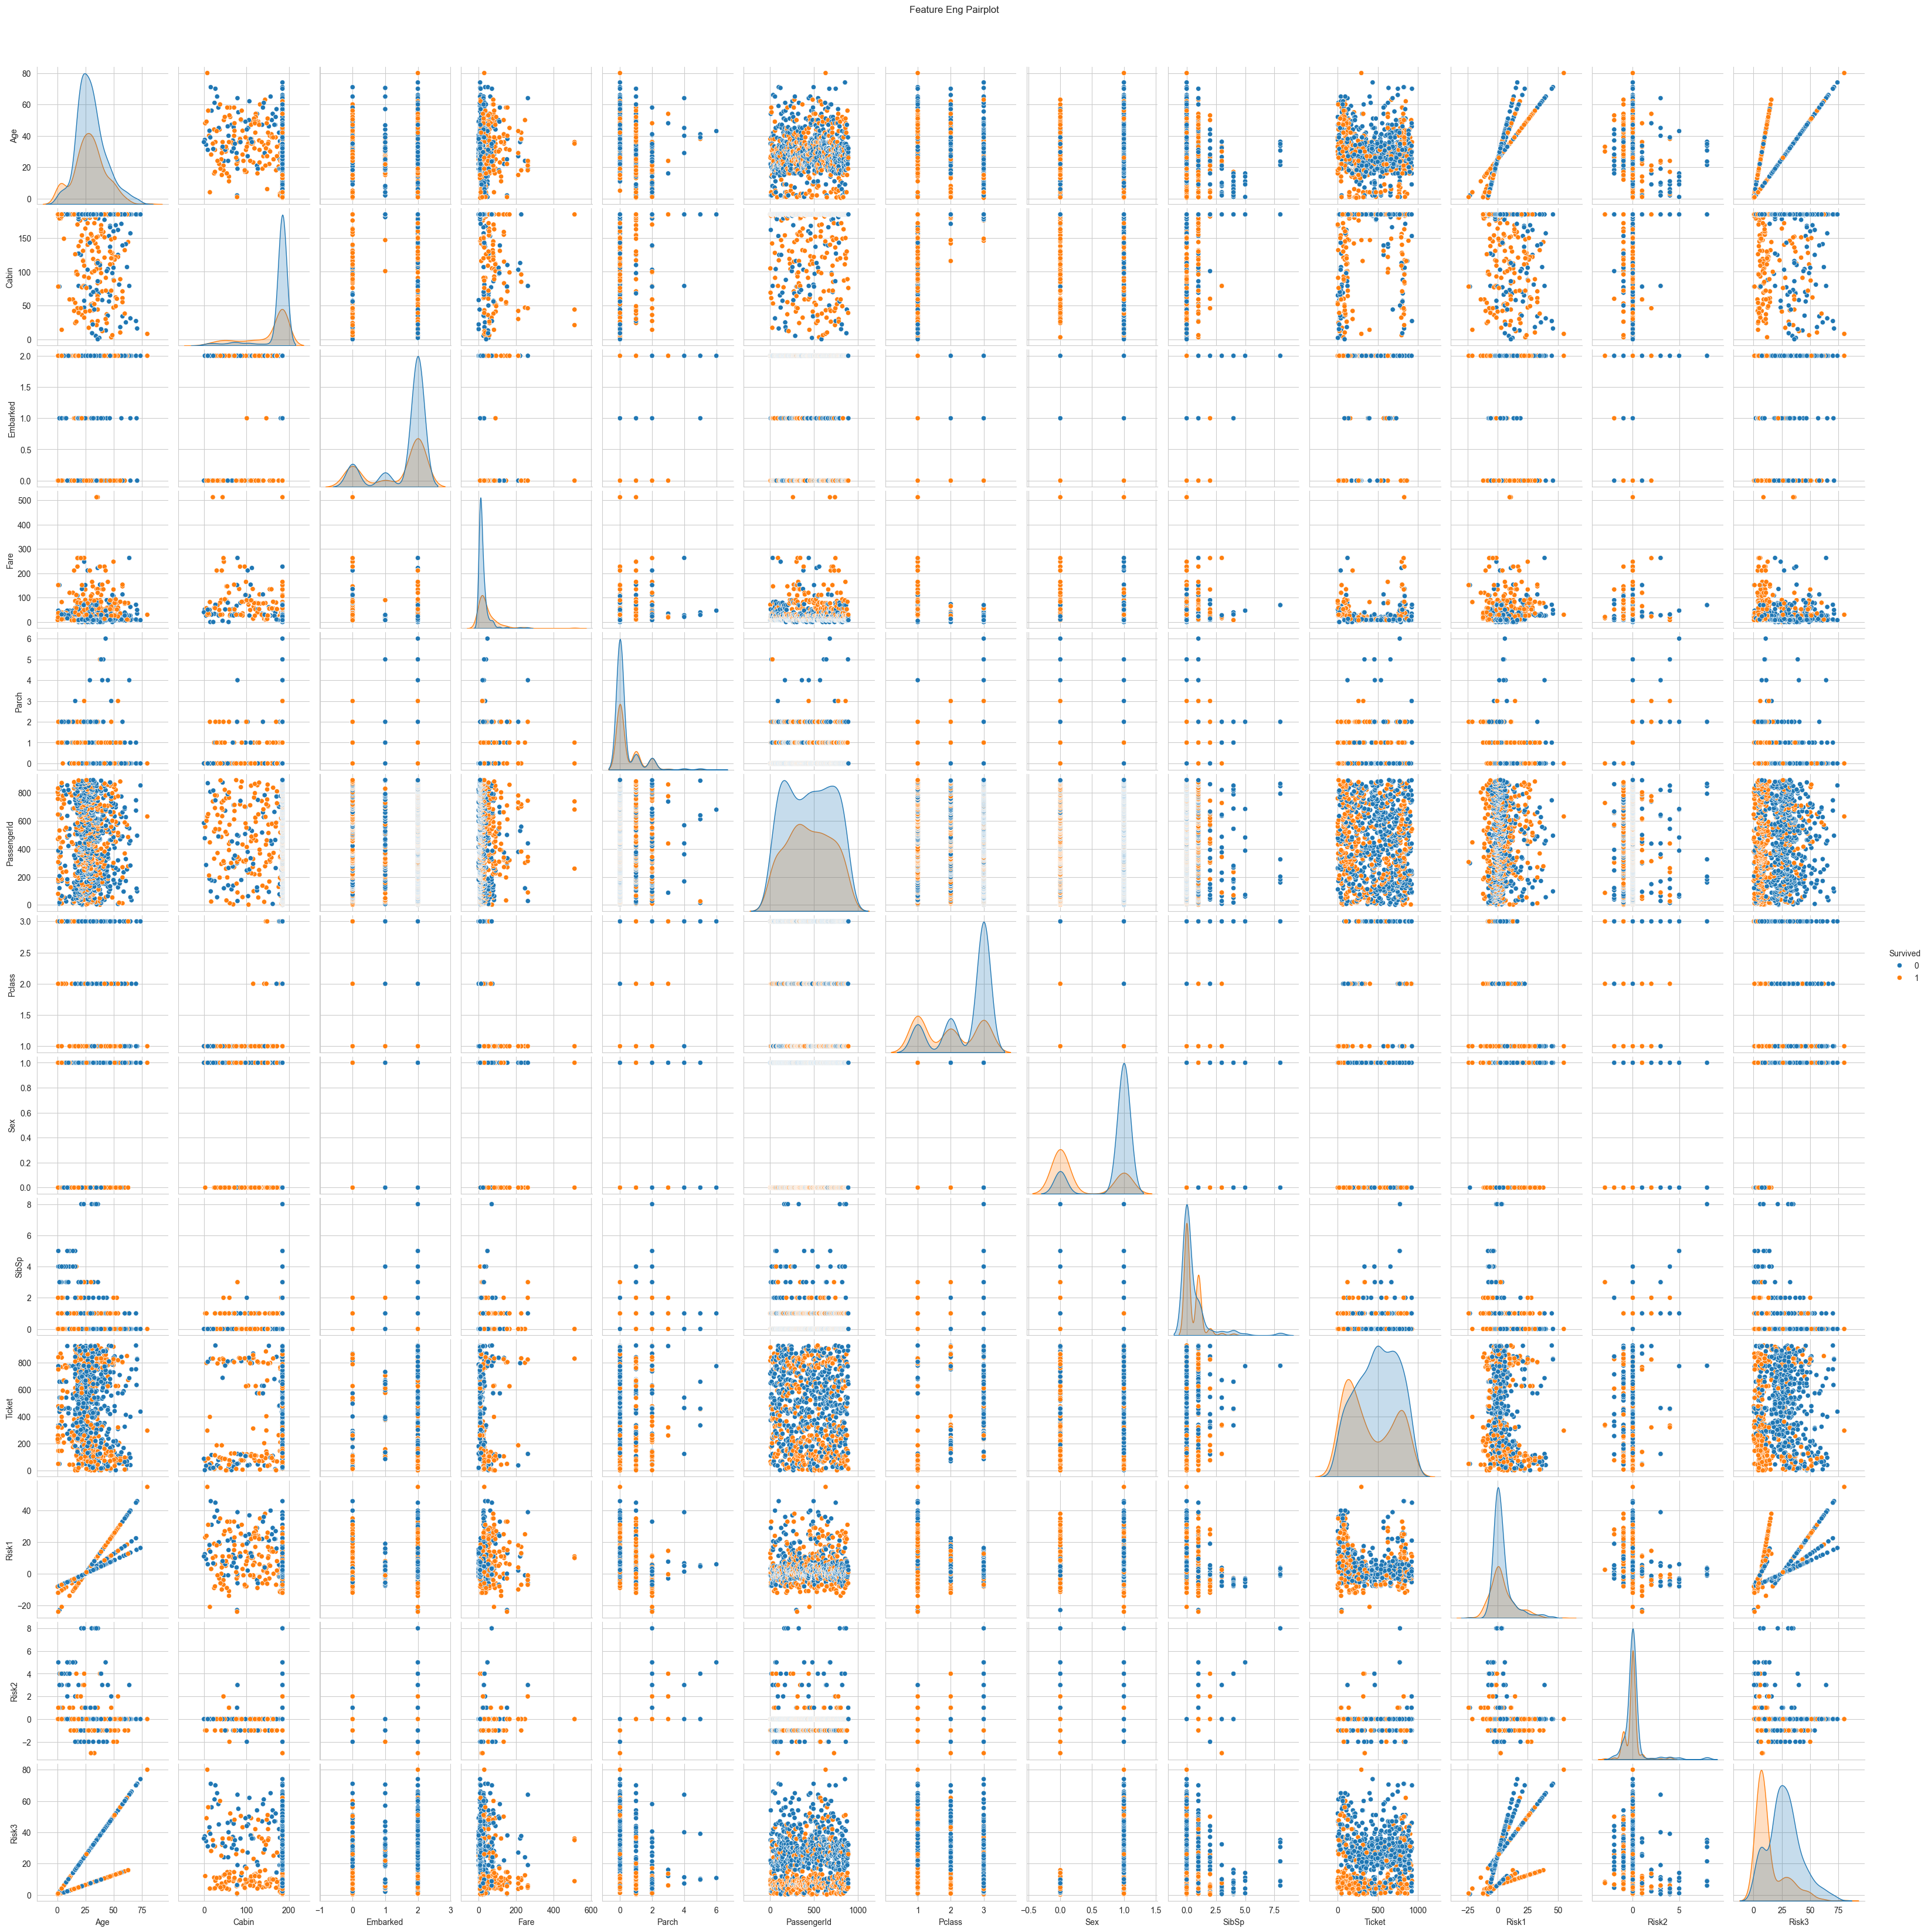

In [184]:
plot_X = pd.concat([X_train,y_train], axis=1)

g2 = sns.pairplot(plot_X, hue="Survived", palette="tab10")
g2.fig.suptitle("Feature Eng Pairplot", y=1.02)
plt.show(g2)

## 5- Fine-Tuning XGBoost

GridSearchCV

In [58]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
xgbc = XGBClassifier()
param_grid = { "eta" : np.linspace(0.04,0.15,9),
                "max_depth" : np.arange(5,10,1)
}

grid = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)
print(f"Best score : {grid.best_score_}")
print(f"Best parameters : {grid.best_params_}")

Best score : 0.8289849552466195
Best parameters : {'eta': 0.05375, 'max_depth': 8}


Advanced Gridsearch

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

param_grid = { "eta" : np.linspace(0.04,0.1,6),
            "max_depth" : np.arange(5,10,1) }

scoring_metrics = { "accuracy" : acc,
                    "precision" : prec,
                    "recall" : rec }

for k in range(2,6,1) :
    selector = SequentialFeatureSelector(estimator=xgbc, n_features_to_select=k, direction="backward", scoring=acc, cv=cv)
    selector.fit(X_train, y_train)
    
    X_train_AD = X_train[X_train.columns[selector.get_support()]]
    X_test_AD = X_test[X_test.columns[selector.get_support()]]

    print(f"SBS avec k = {k}")
    print(f"Features : {X_train_AD.columns}")

    grid = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid.fit(X_train_AD, y_train)
    xgbc = grid.best_estimator_
    #print(f"Best score : {grid.best_score_}")
    print(f"Best parameters : {grid.best_params_}")

    xgbc.fit(X_train_AD, y_train)
    cv_scores = cross_validate(estimator=xgbc, X=X_train_AD, y=y_train, cv=cv, scoring=scoring_metrics)

    acc_scores = cv_scores['test_accuracy']
    prec_scores = cv_scores['test_precision']
    rec_scores = cv_scores['test_recall']

    print(f"Mean accuracy : {acc_scores.mean():.4f} -- Mean precision : {prec_scores.mean():.4f} -- Mean recall : {rec_scores.mean():.4f}")

SBS avec k = 2
Features : Index(['Pclass', 'Risk3'], dtype='object')
Best parameters : {'eta': 0.04, 'max_depth': 8}
Mean accuracy : 0.8132 -- Mean precision : 0.7917 -- Mean recall : 0.6941
SBS avec k = 3
Features : Index(['Fare', 'Pclass', 'Risk3'], dtype='object')
Best parameters : {'eta': 0.04, 'max_depth': 6}
Mean accuracy : 0.8223 -- Mean precision : 0.7930 -- Mean recall : 0.7265
SBS avec k = 4
Features : Index(['Parch', 'Ticket', 'Risk1', 'Risk3'], dtype='object')
Best parameters : {'eta': 0.088, 'max_depth': 5}
Mean accuracy : 0.8043 -- Mean precision : 0.7739 -- Mean recall : 0.7029
SBS avec k = 5
Features : Index(['Age', 'Fare', 'Pclass', 'Ticket', 'Risk3'], dtype='object')
Best parameters : {'eta': 0.064, 'max_depth': 8}
Mean accuracy : 0.8200 -- Mean precision : 0.7939 -- Mean recall : 0.7206


## 6- Prediction with XGBoost

In [75]:
COLS_OPTIM = ['Age', 'Fare', 'Pclass', 'Ticket', 'Risk3']
X_train_optim, X_test_optim = X_train[COLS_OPTIM], X_test[COLS_OPTIM]

eta = 0.064
max_depth = 8

xgbc = XGBClassifier(eta=eta, max_depth=max_depth)
xgbc.fit(X_train_optim, y_train)
y_predict = xgbc.predict(X_test_optim)
y_predict = pd.DataFrame({'PassengerId' : X_test.PassengerId.astype(np.int32),
                          'Survived' : y_predict})

In [76]:
y_predict

PassengerId  Survived
0            892         0
1            893         0
2            894         1
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         0
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

In [77]:
y_predict.to_csv("./../../01_data/13_processed/PassengersPredictionV2.csv", index=False, header=True)

## 7- RandomForestClassifier

In [139]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
forest = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': np.arange(3,10,7),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

scoring_metrics = { "accuracy" : acc,
                    "precision" : prec,
                    "recall" : rec }

for k in range(3,6,1) :
    selector = SequentialFeatureSelector(estimator=forest, n_features_to_select=k, direction="backward", scoring=acc, cv=cv)
    selector.fit(X_train, y_train)
    
    X_train_AD = X_train[X_train.columns[selector.get_support()]]
    X_test_AD = X_test[X_test.columns[selector.get_support()]]

    print(f"SBS avec k = {k}")
    print(f"Features : {X_train_AD.columns}")

    random_search = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, n_iter=10, cv=cv, scoring='accuracy', random_state=1)
    random_search.fit(X_train_AD, y_train)
    forest = random_search.best_estimator_
    #print(f"Best score : {grid.best_score_}")
    print(f"Best parameters : {random_search.best_params_}")

    forest.fit(X_train_AD, y_train)
    cv_scores = cross_validate(estimator=forest, X=X_train_AD, y=y_train, cv=cv, scoring=scoring_metrics)

    acc_scores = cv_scores['test_accuracy']
    prec_scores = cv_scores['test_precision']
    rec_scores = cv_scores['test_recall']

    print(f"Mean accuracy : {acc_scores.mean():.4f} -- Mean precision : {prec_scores.mean():.4f} -- Mean recall : {rec_scores.mean():.4f}")

SBS avec k = 3
Features : Index(['Fare', 'Sex', 'Ticket'], dtype='object')
Best parameters : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Mean accuracy : 0.8268 -- Mean precision : 0.8090 -- Mean recall : 0.7206
SBS avec k = 4
Features : Index(['Sex', 'Ticket', 'Risk1', 'Risk2'], dtype='object')
Best parameters : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Mean accuracy : 0.8358 -- Mean precision : 0.8020 -- Mean recall : 0.7618
SBS avec k = 5
Features : Index(['Fare', 'Pclass', 'Sex', 'Ticket', 'Risk1'], dtype='object')
Best parameters : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Mean accuracy : 0.8323 -- Mean precision : 0.8136 -- Mean recall : 0.7265


In [66]:
COLS_OPTIM = ["Pclass", "Sex", "Parch", "SibSp"]
X_train_optim, X_test_optim = X_train[COLS_OPTIM], X_test[COLS_OPTIM]

cv = StratifiedKFold(n_splits=5, shuffle=True)
forest = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 200, 300],
    'max_depth': np.arange(2,10,1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True]
}

scoring_metrics = { "accuracy" : acc,
                    "precision" : prec,
                    "recall" : rec }

random_search = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, n_iter=10, cv=cv, scoring='accuracy', random_state=1)
random_search.fit(X_train_optim, y_train)
forest = random_search.best_estimator_
print(f"Best parameters : {random_search.best_params_}")

forest.fit(X_train_optim, y_train)
cv_scores = cross_validate(estimator=forest, X=X_train_optim, y=y_train, cv=cv, scoring=scoring_metrics)

acc_scores = cv_scores['test_accuracy']
prec_scores = cv_scores['test_precision']
rec_scores = cv_scores['test_recall']

print(f"Mean accuracy : {acc_scores.mean():.4f} -- Mean precision : {prec_scores.mean():.4f} -- Mean recall : {rec_scores.mean():.4f}")

Best parameters : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'bootstrap': True}
Mean accuracy : 0.8009 -- Mean precision : 0.8031 -- Mean recall : 0.6471
